# AISHELL - 3 - 数据分析报告

In [ ]:
import os
import json
import glob
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import IPython.display as ipd
from tqdm import tqdm

## 挂载 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 解压数据

数据来自：[AISHELL - 3 - 数据下载](https://github.com/wu-jingtao/training-data/blob/master/speech_recognition/chinese/AISHELL-3/notebooks/AISHELL-3-下载数据.ipynb)

In [ ]:
!tar zxvf /content/drive/Shareddrives/TeamDrive_top_edu/原始数据/AISHELL-3/data_aishell3.tgz > unzip_log.txt

## 加载拼音字典

In [ ]:
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_5.json
!wget https://raw.githubusercontent.com/wu-jingtao/training-data/master/speech_recognition/chinese/拼音字典/pinyin_mapper/intonation_0.json

In [ ]:
with open('intonation_5.json') as f:
  pinyin_mapper_intonation_5 = json.load(f)

with open('intonation_0.json') as f:
  pinyin_mapper_intonation_0 = json.load(f)

## 工具方法

查看音频

In [ ]:
# 这个要在执行完 `统计音频时长` 和 `统计句子长度` 之后才能运行
def show_audio(name):
  path = file_list[name]
  audio, sr = librosa.load(path, sr=None)
  text = sentences[name]
  print(''.join(text['words']))
  ipd.display(ipd.Audio(audio, rate=sr))

## 统计音频时长

In [ ]:
# 音频文件列表
file_list = dict()

for path in glob.glob('/content/train/**/*.wav', recursive=True) + glob.glob('/content/test/**/*.wav', recursive=True):
  name = os.path.splitext(os.path.split(path)[1])[0]
  file_list[name] = path

In [ ]:
audio_duration = dict()

for name, path in tqdm(file_list.items()):
  audio_duration[name] = librosa.get_duration(filename=path)

audio_duration = pd.DataFrame.from_dict(audio_duration, orient='index', columns=['duration'])
audio_duration = audio_duration.sort_values('duration', ascending=False)

100%|██████████| 88035/88035 [03:32<00:00, 414.32it/s]


总时长（小时）

In [ ]:
audio_duration.sum() / 3600

duration    85.617826
dtype: float64

总体特征

In [ ]:
audio_duration.describe()

,duration
count,88035.000000
mean,3.501155
std,1.390727
min,0.789478
25%,2.461315
50%,3.205828
75%,4.265986
max,15.719977


时长分布

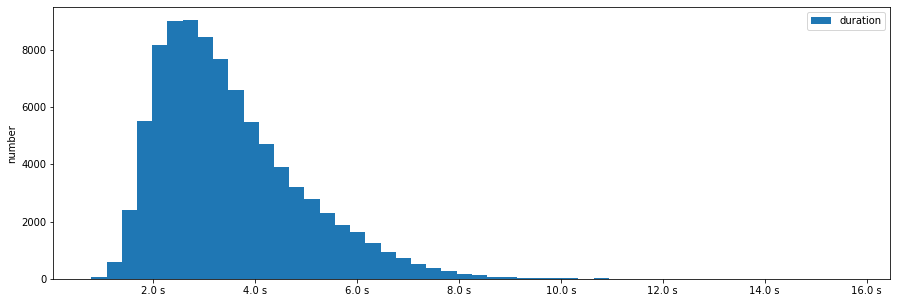

In [ ]:
audio_duration.plot.hist(bins=50, figsize=(15, 5))
plt.ylabel('number')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f s'))

最长的 5 条音频

In [ ]:
audio_duration.head()

,duration
SSB16250279,15.719977
SSB05440247,14.859002
SSB16250105,13.260000
SSB05900401,13.159909
SSB06710228,12.757823


## 统计句子长度

In [ ]:
sentences = dict()

with open('/content/train/content.txt') as f1:
  with open('/content/test/content.txt') as f2:
    for line in f1.readlines() + f2.readlines():
      name, data = line.strip().split('\t')
      name = name[:-4]
      data = data.split(' ')
      sentences[name] = {'words': data[::2], 'pinyins': data[1::2]}

计算字数

In [ ]:
sentences_length = dict()
for k, v in sentences.items():
  sentences_length[k] = len(v['words'])

sentences_length = pd.DataFrame.from_dict(sentences_length, orient='index', columns=['length'])
sentences_length = sentences_length.sort_values('length', ascending=False)

总字数

In [ ]:
sentences_length.sum()

length    997997
dtype: int64

总体特征

In [ ]:
sentences_length.describe()

,length
count,88035.000000
mean,11.336366
std,4.795334
min,1.000000
25%,8.000000
50%,11.000000
75%,14.000000
max,39.000000


长度分布

Text(0, 0.5, 'number')

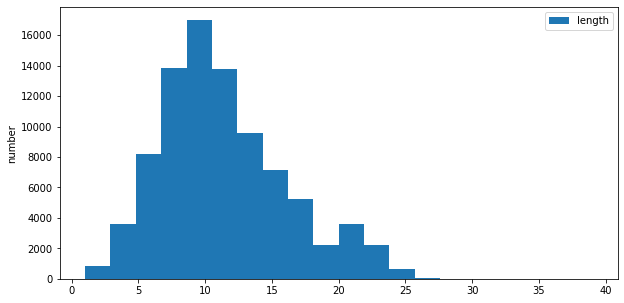

In [ ]:
sentences_length.plot.hist(bins=20, figsize=(10, 5))
plt.ylabel('number')

最长的 5 条句子

In [ ]:
sentences_length.head()

,length
SSB07580116,39
SSB05440038,39
SSB18280009,39
SSB09350475,39
SSB05440247,36


## 统计语速变化

In [ ]:
speed_change = pd.merge(audio_duration, sentences_length, left_index=True, right_index=True)
speed_change = speed_change['duration'] / speed_change['length'] * 1000
speed_change = pd.DataFrame(speed_change, columns=['speed (ms)'])
speed_change = speed_change.sort_values('speed (ms)', ascending=False)

总体特征

In [ ]:
speed_change.describe()

,speed (ms)
count,88035.000000
mean,323.916072
std,77.551836
min,151.196885
25%,275.145165
50%,308.562358
75%,352.724181
max,1599.327286


语速分布

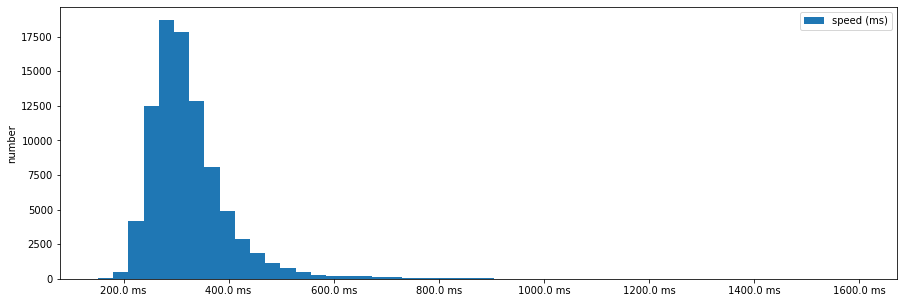

In [ ]:
speed_change.plot.hist(bins=50, figsize=(15, 5))
plt.ylabel('number')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f ms'))

语速最快的 5 条音频

In [ ]:
speed_change.tail().iloc[::-1]

,speed (ms)
SSB06860297,151.196885
SSB06860071,153.276047
SSB06860063,160.586901
SSB05650002,162.597506
SSB06860212,165.000000


语速最慢的 5 条音频

In [ ]:
speed_change.head()

,speed (ms)
SSB03090448,1599.327286
SSB04820009,1374.251701
SSB03950012,1345.986395
SSB07020398,1339.017385
SSB05780202,1252.562358


## 统计发音覆盖范围

### 5 种声调的分布情况

In [ ]:
pinyin_distribution = dict()

for text in sentences.values():
  for i in text['pinyins']:
    # 去除儿化音
    if i not in pinyin_mapper_intonation_5: continue

    if i in pinyin_distribution:
      pinyin_distribution[i] += 1 
    else:
      pinyin_distribution[i] = 1

pinyin_distribution = pd.DataFrame.from_dict(pinyin_distribution, orient='index', columns=['number'])
pinyin_distribution = pinyin_distribution.sort_values('number', ascending=False)

总体特征

In [ ]:
# 从结果来看，这个数据集覆盖到了所有发音，4 种声调的拼音表总共有 1644 种发音，而这里有 1699 种
pinyin_distribution.describe()

,number
count,1699.000000
mean,586.337257
std,1517.893279
min,1.000000
25%,7.000000
50%,73.000000
75%,508.000000
max,33296.000000


发音分布

Text(0, 0.5, 'number')

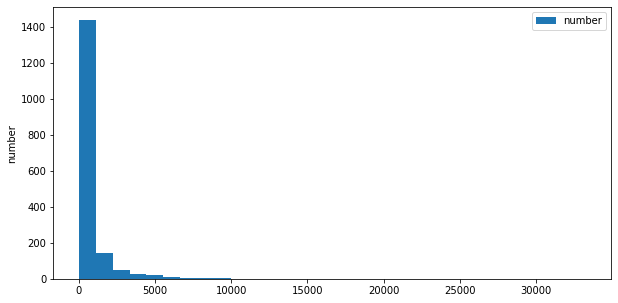

In [ ]:
pinyin_distribution.plot.hist(bins=30, figsize=(10, 5))
plt.ylabel('number')

出现次数前 5 的发音

In [ ]:
pinyin_distribution.head()

,number
de5,33296
shi4,20696
shi2,13834
you3,12152
yi4,9779


### 去除声调后的分布情况

In [ ]:
pinyin_distribution_without_intonation = dict()

for text in sentences.values():
  for i in text['pinyins']:
    # 去除声调
    i = i[:-1]

    # 去除儿化音
    if i not in pinyin_mapper_intonation_0: continue

    if i in pinyin_distribution_without_intonation:
      pinyin_distribution_without_intonation[i] += 1 
    else:
      pinyin_distribution_without_intonation[i] = 1

pinyin_distribution_without_intonation = pd.DataFrame.from_dict(pinyin_distribution_without_intonation, orient='index', columns=['number'])
pinyin_distribution_without_intonation = pinyin_distribution_without_intonation.sort_values('number', ascending=False)

总体特征

In [ ]:
# 从结果来看，不带声调的发音覆盖的非常好，不带声调的拼音表有411种发音，这里有404种
pinyin_distribution_without_intonation.describe()

,number
count,404.000000
mean,2465.809406
std,3866.411866
min,2.000000
25%,327.750000
50%,1125.500000
75%,2896.500000
max,37809.000000


发音分布

Text(0, 0.5, 'number')

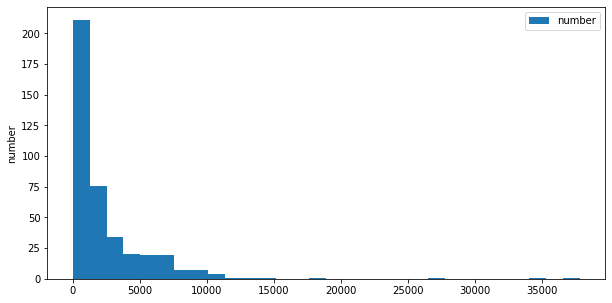

In [ ]:
pinyin_distribution_without_intonation.plot.hist(bins=30, figsize=(10, 5))
plt.ylabel('number')

出现次数前 5 的发音

In [ ]:
pinyin_distribution_without_intonation.head()

,number
shi,37809
de,35180
yi,27469
you,18358
ji,15007
